In [3]:
# import libaries 1

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import SimpleITK as sitk
# import radiomics 
import six,numpy as np
import os
import csv
import pandas as pd
import seaborn as sn
import pylab as pl
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
# import glmnet_py
import math
import scipy.stats

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
from sklearn.feature_selection import GenericUnivariateSelect, VarianceThreshold, mutual_info_classif, SelectFromModel, SelectKBest, SelectPercentile, f_classif, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV, ridge_regression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, OrthogonalMatchingPursuit, MultiTaskLasso, LassoLars, Lars, RidgeCV, ElasticNet, ElasticNetCV, LogisticRegression, LassoLarsCV, LassoCV, LinearRegression, Ridge, Lasso, lasso_path, enet_path
from sklearn.model_selection import LeaveOneOut, cross_validate, cross_val_predict, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

In [5]:
from matplotlib import pyplot as plt
from radiomics import featureextractor,imageoperations
from pandas import Series, DataFrame 

from scipy import stats

from glmnet import glmnet
# from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
# from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
# from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

ModuleNotFoundError: No module named 'radiomics'

In [10]:
# Import csv files 

file = '/home/gpuadmin/anaconda3/envs/py380/Work/pyradiomics/radiomics/radiomics_ADC134nT2_104_Tz_MWU_new.csv'
data = pd.read_csv(file)
target = data['Class']
target = target.astype(np.float64)
feature = data.loc[:,data.columns != 'Class']
feature = feature.loc[:,feature.columns != 'GG']
feature = feature.loc[:,feature.columns != 'Subjects']
reader = csv.DictReader(open(file))

In [11]:
# Feature by modality 

# 1. radiomics_ADC134nT2_104_MWU_new.csv

# feature_ADC1 = feature.iloc[:,0:61]
# feature_ADC3 = feature.iloc[:,61:110]
# feature_ADC4 = feature.iloc[:,110:160]
# feature_nT2 = feature.iloc[:,160:223]
# feature_nT2_resample = feature.iloc[:,223:310]

# 2. radiomics_ADC134nT2_105_Pz_MWU_new.csv

# feature_ADC1 = feature.iloc[:,0:55]
# feature_ADC3 = feature.iloc[:,55:83]
# feature_ADC4 = feature.iloc[:,83:103]
# feature_nT2 = feature.iloc[:,103:124]
# feature_nT2_resample = feature.iloc[:,124:178]

# 3 radiomics_ADC134nT2_104_Tz_MWU_new.csv

feature_ADC1 = feature.iloc[:,0:27]
feature_ADC3 = feature.iloc[:,27:48]
feature_ADC4 = feature.iloc[:,48:67]
feature_nT2 = feature.iloc[:,67:70]
feature_nT2_resample = feature.iloc[:,70:110]

In [12]:
# define feature 

feature_final = feature_ADC1
features = pd.DataFrame(feature_final)

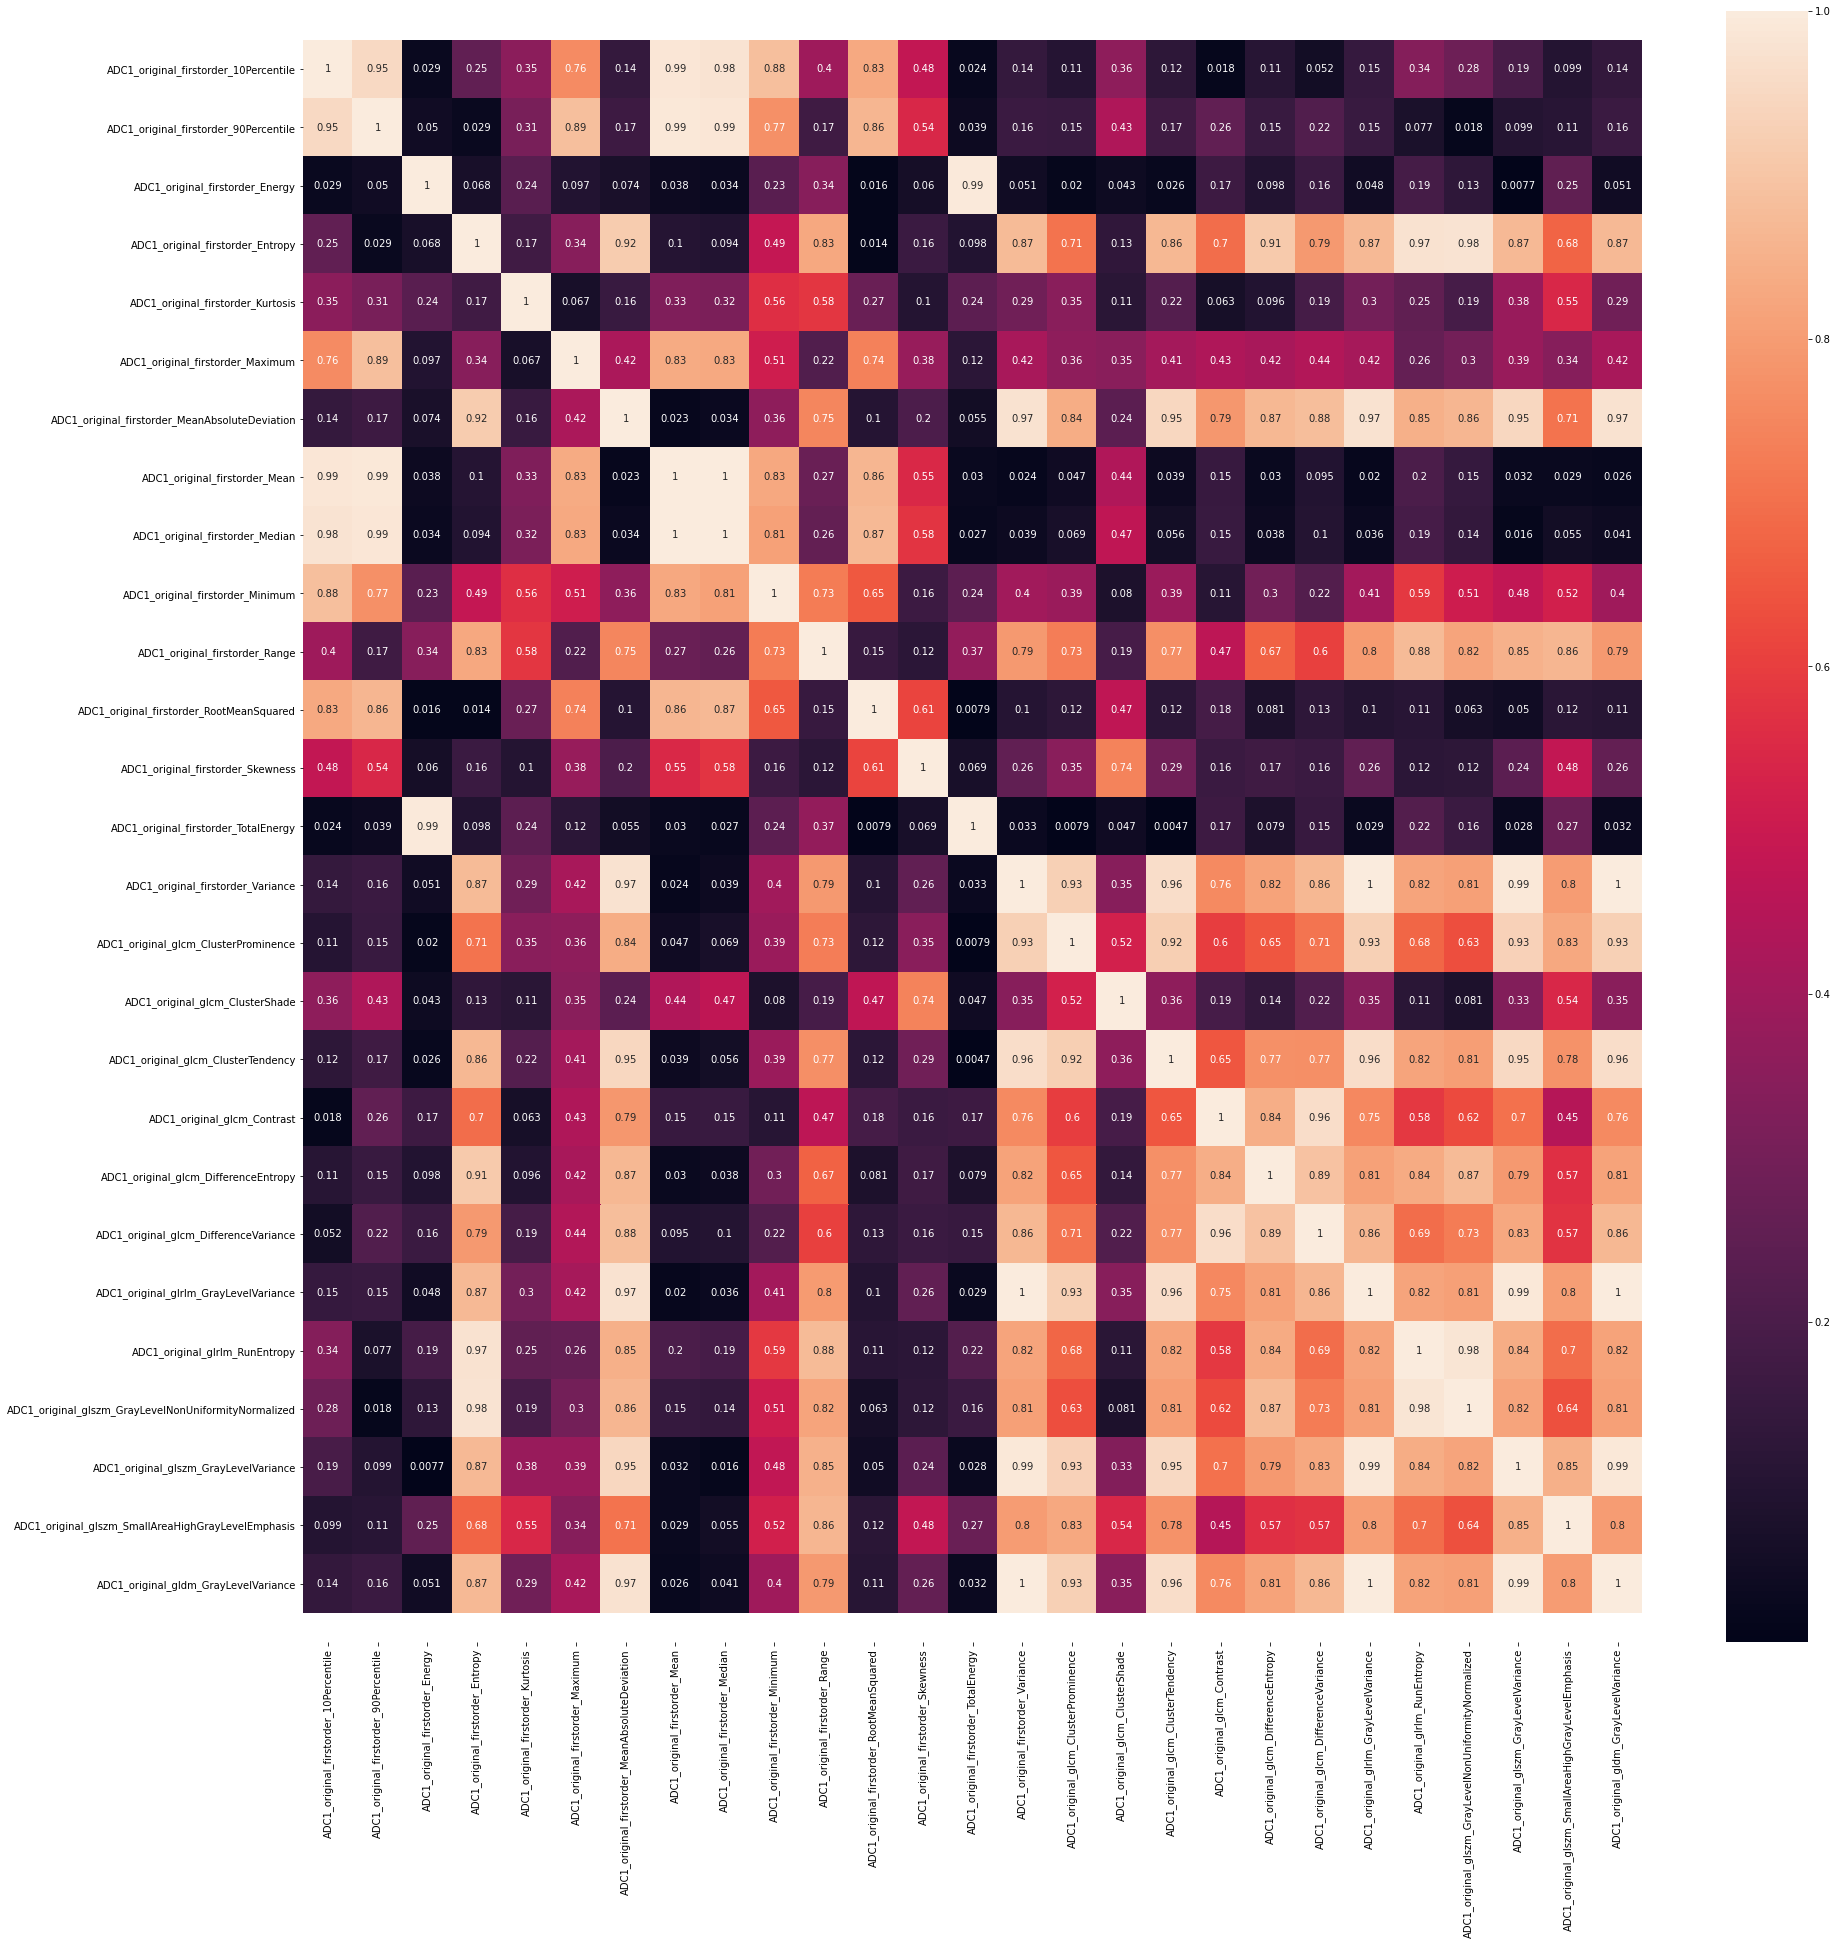

(56, 27)
(56, 14)


In [13]:
# corrleation analysis to eliminate one of the highly correlated features 

imp_feat = features

f = plt.subplots(figsize=(30,30))
corr_mat = imp_feat.corr().abs()
ax = sn.heatmap(corr_mat,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
print(imp_feat.shape)

col_corr = set() # Set of all the names of deleted columns
threshold = 0.9
corr_matrix = imp_feat.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
            colname = corr_matrix.columns[i] # getting the name of column
            col_corr.add(colname)
            if colname in imp_feat.columns:
                del imp_feat[colname] # deleting the column from the dataset
                
features = imp_feat
print(features.shape)

In [14]:
# Train and test sets split 

# name = reader.fieldnames[1:]
name = features.columns
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size = 0.25, random_state = 6)

In [15]:
# Data normalization

scaler = StandardScaler()
encoder = LabelEncoder()
feature_train = scaler.fit_transform(feature_train)
feature_test = scaler.fit_transform(feature_test)
encoder.fit(target_train)
encoder.fit(target_test)
target_train = encoder.fit_transform(target_train)
target_test = encoder.fit_transform(target_test)

In [16]:
print(feature_train.shape)
print(target_train.shape)
print(feature_test.shape)
print(target_test.shape)

(42, 14)
(42,)
(14, 14)
(14,)


In [17]:
# LASSO regularization: to determine alpha and important features 

lassocv = LassoCV(eps = 0.001, n_alphas = 100, alphas = None, cv = 5, max_iter = 10000000, normalize = True)
lassocv.fit(feature_train,target_train)

print("Alpha =", lassocv.alpha_)
train_model_score = lassocv.score(feature_train, target_train)
test_model_score = lassocv.score(feature_test, target_test)
coff_used = np.sum(lassocv.coef_ != 0)

print("mse =",mean_squared_error(target_test, lassocv.predict(feature_test)))
print("Number of features used:", coff_used)

feature_train_inframe = pd.DataFrame(feature_train)
features = pd.Series(lassocv.coef_, index = feature_train_inframe.columns)

for i,v in enumerate(np.nonzero([features])):
    print(v)
    
x = v.astype(int)
imp_feature_name = list()
imp_feature_val = list()
imp_feature_ind = list()
for i in range(x.shape[0]):
    ind = features.index[x[i]]
    feat = name[x[i]]
    val = features.values[x[i]]
    print(ind, feat, val)
    imp_feature_name.append(feat)
    imp_feature_val.append(val)
    imp_feature_ind.append(ind)

Alpha = 0.007472328962079327
mse = 0.10567630388194227
Number of features used: 3
[0 0 0]
[0 7 8]
0 ADC1_original_firstorder_10Percentile -0.11370140069506081
7 ADC1_original_firstorder_RootMeanSquared -0.13329984618112956
8 ADC1_original_firstorder_Skewness 0.18209806905051204


In [18]:
# LASSO regularization: list important features selected from LASSO regularization  

model = lassocv
sfm = SelectFromModel(model, threshold=0.00001)
sfm.fit(feature_train,target_train)

imp_feature_train = sfm.transform(feature_train)
imp_feature_test = sfm.transform(feature_test)

# feature_train = imp_feature_train
# feature_test = imp_feature_test

# LASSO regularization: classification and cross validation using LASSO linear regression 

cv = KFold(5, shuffle = True, random_state = 3)
# cv = LeaveOneOut()
# scores_loo = cross_val_score(model, feature_train, target_train, cv=cv) 
cvscore = cross_val_score(model, feature_train, target_train, scoring = "r2", cv = cv)
# cvresult = cross_validate(lassocv, feature_train, target_train, cv=cv, return_train_score=True)
cvprediction = cross_val_predict(model, feature_train, target_train, cv = cv)
predicted = cvprediction.round()

for i in range(predicted.shape[0]):
    if predicted[i] > 1.0: 
        predicted[i] = 1
    if predicted[i] <= -1.0:
        predicted[i] = 0
            
accuracy = accuracy_score(target_train,abs(predicted))

tn_train, fp_train, fn_train, tp_train = confusion_matrix(target_train, abs(predicted)).ravel()
sensitivity_train = tp_train / (tp_train + fn_train)
specificity_train = tn_train / (tn_train + fp_train)
auctraining = roc_auc_score(target_train, abs(cvprediction))

print("Classification accuracy on training set after k-fold cross validation: {:2f}".format(accuracy))
print("Sensitivity on training set: {:2f}".format(sensitivity_train))
print("Specificity on training set: {:2f}".format(specificity_train))
print("Training score after k-fold cross validation:", cvscore.mean())

target_test_pred = model.predict(feature_test)
asall_test = accuracy_score(target_test, target_test_pred.round())
auctest = roc_auc_score(target_test, target_test_pred)
predicted_test = target_test_pred.round()

for i in range(predicted_test.shape[0]):
    if predicted_test[i] > 1.0: 
        predicted_test[i] = 1
    if predicted_test[i] <= -1.0:
        predicted_test[i] = 0

tn_test, fp_test, fn_test, tp_test = confusion_matrix(target_test, abs(predicted_test)).ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

print("Classification accuracy on test set: {:2f}".format(asall_test))
print("Sensitivity on test set: {:2f}".format(sensitivity_test))
print("Specificity on test set: {:2f}".format(specificity_test))
print("Test score:", test_model_score)
print("Area under the ROC curve (training): {:2f}".format(auctraining))
print("Area under the ROC curve (test): {:2f}".format(auctest))

Classification accuracy on training set after k-fold cross validation: 0.880952
Sensitivity on training set: 0.900000
Specificity on training set: 0.863636
Training score after k-fold cross validation: 0.4756858835987591
Classification accuracy on test set: 1.000000
Sensitivity on test set: 1.000000
Specificity on test set: 1.000000
Test score: 0.5684884258154024
Area under the ROC curve (training): 0.911364
Area under the ROC curve (test): 1.000000


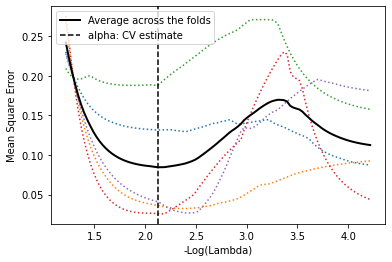

In [19]:
# LASSO regularization: for mean square error plot with respect to alpha (lambda)

model = lassocv

m_log_alphas = -np.log10(model.alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-Log(Lambda)')
plt.ylabel('Mean Square Error')
plt.axis('tight')
plt.show()

In [20]:
# call glmnet

t = scipy.ones((50, 1), dtype = scipy.float64)
wts = scipy.row_stack((t, 2*t))

fit = glmnet(x = scipy.float64(feature_train), y = scipy.float64(target_train), family = 'gaussian', alpha = 0.2, nlambda = 20)
glmnetPrint(fit)
glmnetPlot(fit, xvar = 'lambda', label = True)
glmnetPlot(fit, xvar = 'dev', label = True)
glmnetCoef(fit, s = scipy.float64([0.5]), exact = False)
# glmnetPredict(fit, x[0:5,:], ptype = 'response', s = scipy.float64([0.05]))

cl = scipy.array([[-0.7], [0.5]], dtype = scipy.float64)
tfit=glmnet(x = scipy.float64(feature_train),y = scipy.float64(target_train), cl = cl)
glmnetPlot(tfit);

<ipython-input-20-33d8347db755>:3: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  t = scipy.ones((50, 1), dtype = scipy.float64)
<ipython-input-20-33d8347db755>:4: DeprecationWarning: scipy.row_stack is deprecated and will be removed in SciPy 2.0.0, use numpy.row_stack instead
  wts = scipy.row_stack((t, 2*t))


NameError: name 'glmnet' is not defined

In [471]:
# AUC: with 95% CI 

def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:http://localhost:8888/notebooks/Documents/pyradiomics-master/notebooks/radiomics_lassocv.ipynb
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


alpha = .95
auc_train, auc_cov_train = delong_roc_variance(target_train,abs(cvprediction))
auc_test, auc_cov_test = delong_roc_variance(target_test,abs(predicted_test))

auc_std_train = np.sqrt(auc_cov_train)
auc_std_test = np.sqrt(auc_cov_test)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci_train = stats.norm.ppf(
    lower_upper_q,
    loc=auc_train,
    scale=auc_std_train)

ci_test = stats.norm.ppf(
    lower_upper_q,
    loc=auc_test,
    scale=auc_std_test)

ci_train[ci_train > 1] = 1
ci_test[ci_test > 1] = 1

print('AUC (train):', auc_train)
print('AUC COV (train):', auc_cov_train)
print('95% AUC CI (train):', ci_train)

print('AUC (test):', auc_test)
print('AUC COV (test):', auc_cov_test)
print('95% AUC CI (test):', ci_test)

AUC (train): 0.9113636363636364
AUC COV (train): 0.003392028625282213
95% AUC CI (train): [0.79721313 1.        ]
AUC (test): 1.0
AUC COV (test): 0.0
95% AUC CI (test): [nan nan]


/home/gpuadmin/anaconda3/envs/py380/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/gpuadmin/anaconda3/envs/py380/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
